## Import Libraries

In [ ]:
>>> import nltk
>>> nltk.download('stopwords')
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import spacy
lang = spacy.load('en')
stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU Model    Tesla T4


## Confusion Matrix Method

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Cleaning Data, Preprocessing

In [ ]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral" or "neutral" :
            y.values[i]=0
        else:
            y.values[i]=1
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y


## Load Dataset and Process

In [ ]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")

X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

print("Neutral Examples : ",(X['Target']==0).sum())
print("Not Neutral Examples : ",(X['Target']==1).sum())


Number of Examples :  65590 

Number of Examples after removing duplicates:  65085 

Number of words before cleaning :  2528608
Number of words after cleaning :  1678934

******************

Neutral Examples :  32563
Not Neutral Examples :  32522


## Stemming

In [ ]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])
Xv = X['Article'].to_frame()

X_train,X_test,y_train,y_test = train_test_split(Xv,X['Target'], test_size=0.3,stratify=X['Target'])
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.3,stratify=y_train)

ros = RandomOverSampler()
X_train,y_train = ros.fit_resample(X_train, y_train)

train=pd.DataFrame(columns=['Article','Target'])
val = pd.DataFrame(columns=['Article','Target'])
test= pd.DataFrame(columns=['Article','Target'])


df = pd.DataFrame(data = X_train,columns=['Article'])
df1= pd.DataFrame(data = y_train,columns=['Target'])
train['Article']=df['Article']
train['Target']=df1['Target']
df = pd.DataFrame(data = X_test,columns=['Article'])
df1= pd.DataFrame(data = y_test,columns=['Target'])
test['Article']=df['Article']
test['Target']=df1['Target']
df = pd.DataFrame(data = X_val,columns=['Article'])
df1= pd.DataFrame(data = y_val,columns=['Target'])
val['Article']=df['Article']
val['Target']=df1['Target']

print("\n")
print("\nNeutral Examples in Training after OverSampling: ",(train['Target']==0).sum())
print("Not Neutral Examples in Training after OverSampling: ",(train['Target']==1).sum())


train.to_csv (r'Train_General.csv', index = False, header=True)
test.to_csv (r'Test_General.csv', index = False, header=True)
val.to_csv (r'Val_General.csv', index = False, header=True)


0        nyse presid coronaviru see unpreced uncertain ...
1                  big stock fundament big stock fundament
2        weekli updat good dose fear void common sens w...
3        sell panic may miss market best day bank ameri...
4        wall street wildest week year wall street anot...
                               ...                        
65080    macroview astonish lack valu valu macroview as...
65081    post crash reflat trade fade post crash reflat...
65082    septemb selloff healthi correct start new bear...
65083    geeli maker polestar plan new plant precept mo...
65084    china gac bmw expect china sale grow year chin...
Name: Article, Length: 65085, dtype: object



Neutral Examples in Training after OverSampling:  15956
Not Neutral Examples in Training after OverSampling:  15956


## Build Vocabulary

In [ ]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

#TEXT = data.Field(tokenize='spacy',batch_first=True)
TEXT = data.Field(batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
X_train=data.TabularDataset(path = 'Train_General.csv',format = 'csv',fields = fields,skip_header = True)
X_test=data.TabularDataset(path = 'Test_General.csv',format = 'csv',fields = fields,skip_header = True)
X_val=data.TabularDataset(path = 'Val_General.csv',format = 'csv',fields = fields,skip_header = True)

TEXT.build_vocab(X_train)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  




Size of TEXT vocabulary: 26163
Size of LABEL vocabulary: 2
[('stock', 12547), ('earn', 8335), ('compani', 7343), ('inc', 6840), ('market', 6715), ('announc', 6548), ('report', 5638), ('investor', 5359), ('new', 5005), ('busi', 4770)]


## Accuracy, Loss and Optimizer Function

In [ ]:
def find_accuracy(preds, y):
    real_values=torch.sigmoid(preds)
    temp = torch.round(real_values)
    valid = (temp == y).float() 
    accur = valid.sum() / len(valid)
    return accur,temp,y,real_values

def Loss_Optimizer (model,valueLR):
    criterion = nn.BCEWithLogitsLoss()
    #criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

## Training and Testing Functions 

In [ ]:
def train(model,data,lr,optimizer,criterion):
        
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text = i.text   
        optimizer.zero_grad()
        pred = model(text).squeeze(1)    
        loss = criterion(pred, i.label)
        acc,_,_,_ = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    real_v_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text = i.text
            
            pred = model(text).squeeze(1)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true,real_v = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
            real_v_list+=real_v.flatten().tolist()
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list,real_v_list

def process_test(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_ ,_= test(model, data_val, criterion)
        
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
     
    return real_v_list

def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
        
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,_,_,_ = test(model, data_val, criterion)
        
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list, real_v_list= test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1])
    np.set_printoptions(precision=3)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix, with normalization')
    return real_v_list

## RNN Models

In [ ]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
       
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text):
                
        embedded = self.dropout(self.embedding(input_text))
        
        rnn_out,hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        out=self.fc(hidden.squeeze(0))
        return out

In [ ]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 1
batch=1024
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  
dropout = 0.5

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(26163, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
myGRU(
  (embedding): Embedding(26163, 300)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Epoch :  5  Train Loss :  0.35569826283608563   Train Acc :  0.826263427734375   Valid Loss :  0.39018346761752454  Val Acc :  0.8267996651785714
Epoch :  10  Train Loss :  0.2696282107699517   Train Acc :  0.87689208984375   Valid Loss :  0.42536925261707176  Val Acc :  0.8349695588861193
Epoch :  15  Train Loss :  0.2031636537903978   Train Acc :  0.91259765625   Valid Loss :  0.5570667746609875  Val Acc :  0.839922125850405
Epoch :  20  Train Loss :  0.15806442779291885   Train Acc :  0.934051513671875   Valid Loss :  0.6137173884947386  Val Acc :  0.8338621088436672
Epoch :  25  Train Loss :  0.1149581924338463   Train Acc :  0.9539794921875   Valid Loss :  0.7571135740727186  Val Acc :  0.8354578401361193
Epoch :  30  Train Loss :  0.09556958471125654   Train Acc :  0.961669921875   Valid Loss :  0.8244913557012167  Val Acc :  0.8308540454932621

Time needed for Training :  3.788988208770752

Loss in Testset :  0.5522606342403378   Accuracy in Testset :  0.837841796875 

Normalize

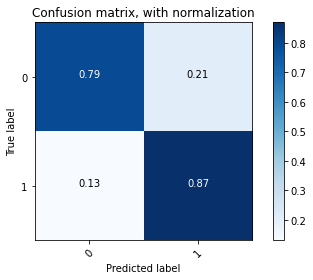

In [ ]:
lstm_list=process_test(new_model2,30,train_it,val_it,test_it,0.001,"LSTM_Gen_NeutnotNeut_model.pt")

Epoch :  5  Train Loss :  0.35686849273042753   Train Acc :  0.827117919921875   Valid Loss :  0.38891423267445396  Val Acc :  0.8294675775936672
Epoch :  10  Train Loss :  0.2865091884486901   Train Acc :  0.8697509765625   Valid Loss :  0.3737216472093548  Val Acc :  0.8353967070579529
Epoch :  15  Train Loss :  0.22807709405788046   Train Acc :  0.90057373046875   Valid Loss :  0.4985799217663173  Val Acc :  0.8343417687075478
Epoch :  20  Train Loss :  0.1795982423896021   Train Acc :  0.925506591796875   Valid Loss :  0.5510101948332574  Val Acc :  0.8328855463436672
Epoch :  25  Train Loss :  0.14242163353436865   Train Acc :  0.943206787109375   Valid Loss :  0.6442668448934066  Val Acc :  0.8310021758079529
Epoch :  30  Train Loss :  0.11818952747729838   Train Acc :  0.952056884765625   Valid Loss :  0.7416502148844302  Val Acc :  0.8333565848214286

Time needed for Training :  3.092841458320618

Loss in Testset :  0.46068633653194413   Accuracy in Testset :  0.8365234375 

No

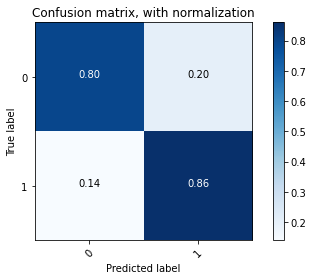

In [ ]:
gru_list=process_test(new_model3,30,train_it,val_it,test_it,0.001,"GRU_Gen_NeutnotNeut_model.pt")

## Testing Function for individual text

In [ ]:
def sentence(model, s):
    model.eval()
    
    token = [tok.text for tok in lang.tokenizer(s)]
    index = [TEXT.vocab.stoi[t] for t in token]
    tensor = torch.LongTensor(index).to(device)
    tensor = tensor.unsqueeze(0)
    pred = torch.sigmoid(model(tensor))
    return pred.item()


## Evaluate Neutrals (maybe some of them are not)

In [ ]:
Neutral_pd=X[X['Target'] == 0.0]
Neutral_pd.index = range(len(Neutral_pd))
v_list=[]
for index, row in Neutral_pd.iterrows():
    v=sentence(new_model3,Neutral_pd['Article'][index])
    v_list.append(v)
    if v>0.7:
      Neutral_pd['Target'][index]=1.0
    else:
      Neutral_pd['Target'][index]=0.0
Neutral_pd=Neutral_pd[Neutral_pd['Target'] == 1.0] 

print("Number of Neutrals than maybe are not : " ,len(Neutral_pd), " from GRU")

Neutral_pd2=X[X['Target'] == 0.0]
Neutral_pd2.index = range(len(Neutral_pd2))

v_list2=[]
for index, row in Neutral_pd2.iterrows():
    v=sentence(new_model2,Neutral_pd2['Article'][index])
    v_list2.append(v)
    if v>0.7:
      Neutral_pd2['Target'][index]=1.0
    else:
      Neutral_pd2['Target'][index]=0.0
Neutral_pd2=Neutral_pd2[Neutral_pd2['Target'] == 1.0] 

print("Number of Neutrals than maybe are not : " ,len(Neutral_pd2), " from LSTM")

# Combine 2 results from GRU and LSTM

Neutral_pd=Neutral_pd.merge(Neutral_pd2)

print("\nNumber of Neutrals that might be not Neutrals that agree LSTM and GRU : ",len(Neutral_pd))

Neutral_pd.index = range(len(Neutral_pd))



Neutral_pd.to_csv (r'new_Neutral_General.csv', index = False, header=True)

Number of Neutrals than maybe are not :  3305  from GRU
Number of Neutrals than maybe are not :  3312  from LSTM

Number of Neutrals that might be not Neutrals that agree LSTM and GRU :  2276


## Plot the distribution of Neutrals

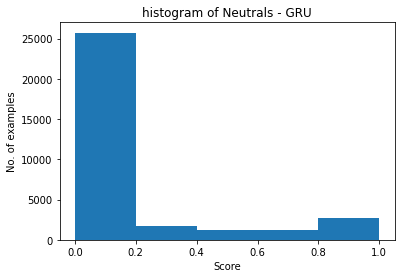

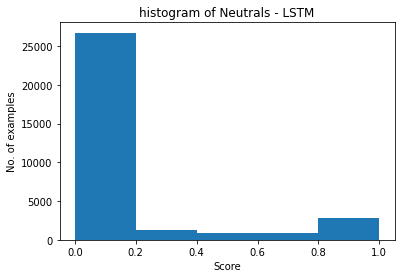

In [ ]:
fig,ax = plt.subplots(1,1)

ax.hist(v_list, bins = [0,0.2,0.4,0.6,0.8,1])
ax.set_title("histogram of Neutrals - GRU")
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xlabel('Score')
ax.set_ylabel('No. of examples')
plt.show()

fig,ax = plt.subplots(1,1)

ax.hist(v_list2, bins = [0,0.2,0.4,0.6,0.8,1])
ax.set_title("histogram of Neutrals - LSTM")
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_xlabel('Score')
ax.set_ylabel('No. of examples')
plt.show()